### They inner atoms, and the outer atoms are equally spaced
### Find out the N-dependance

In [1]:
from tqdm import tqdm
from qutip import *
import numpy as np

from scipy.optimize import minimize

import os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial

In [2]:
save_path = r'C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [46]:
# Define constants
fixed_lam = 1
fixed_gamma = 1
fixed_dist_ext = 0.235 * fixed_lam
fixed_dist_in = fixed_dist_ext

t_max = 100
t_size = 200
times = np.linspace(0, t_max, t_size) * fixed_gamma

# Define the geometry functions
def dipole_vector(phi=0):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])

def chain_positions(distance, N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i, 0] = i * distance
    return Pos

def topo_positions(distance_in=fixed_dist_in, distance_ext=fixed_dist_ext, N=6):
    Pos = np.zeros((N, 3))
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(distance_ext, N // 3) + [r, 0, 0]
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(2 * np.pi / 6).T)
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-2 * np.pi / 6).T)
    return Pos

def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
            * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
               + (- kappa ** 2 - 3 * 1j * kappa + 3)
               * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma, N):
    positions = topo_positions(distance_in, distance_ext, N)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                G_matrix[a, b] = np.imag((6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return G_matrix

def V_matrix(distance_in, distance_ext, dipoles, lam, gamma, N):
    positions = topo_positions(distance_in, distance_ext, N)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                V_matrix[a, b] = np.real((3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return V_matrix
    
def H_eff(distance_in=fixed_dist_in, distance_ext=fixed_dist_ext, dipoles=None, lam=fixed_lam, gamma=fixed_gamma, N=6):
    if dipoles is None:
        dipoles = [dipole_vector() for _ in range(N)]
    G = Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma, N)
    V = V_matrix(distance_in, distance_ext, dipoles, lam, gamma, N)
    return Qobj(V) - 1j / 2 * Qobj(G)

# Initialize wave-packet
k_s = np.pi / fixed_dist_ext
sigma = 0.1 * k_s

def create_wave_packet(N):
    center_index = N // 6
    x_j = (np.arange(N//3) - center_index) * fixed_dist_ext
    coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
    wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
    return wave_packet.unit()

# Functions for optimization
def survival_probabilities(dipoles, distance_in, times, distance_ext=fixed_dist_ext, lam=fixed_lam, gamma=fixed_gamma, Psi_0=None, N=6):
    H = H_eff(distance_in, distance_ext, dipoles, lam, gamma, N)
    coeffs_sq_mods = np.zeros((len(times), N))
    P_surs = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

def dipole_angles_and_distance(params, N):
    angles = params[:N]
    distance_in = params[N]
    dipoles = [dipole_vector(angle) for angle in angles]
    return dipoles, distance_in

def optimization_target(params, times, target_indices, Psi_0, N):
    dipoles, distance_in = dipole_angles_and_distance(params, N)
    res, _ = survival_probabilities(dipoles, distance_in, times, Psi_0=Psi_0, N=N)
    # Sum probabilities of the states in the target indices
    target_prob = np.sum(res[-1, target_indices])
    # We want to maximize the target probability
    return -target_prob

def extend_initial_params(old_params, old_N, new_N):
    """Extend the initial parameters from old_N to new_N with specific positioning for new atoms."""
    old_angles = old_params[:old_N]
    old_distance = old_params[old_N]

    # Initialize new angles with old angles
    new_angles = np.zeros(new_N)
    
    # Copy old angles to their respective positions in the new array
    new_angles[2:2 * old_N // 3 + 2] = old_angles[:2* old_N // 3]  # Upper arm part 1
    new_angles[4 + 2 * old_N // 3:new_N -2] = old_angles[2*old_N// 3:old_N -1]  # Upper arm part 2
    
    new_params = np.hstack((new_angles, old_distance))
    return new_params

In [47]:
# Optimization results
optimization_results = {}

# Loop over multiples of 6
for N in range(6, 61, 6):
    print(f"Optimizing for N = {N}")
    if N == 6:
        initial_distance = 0.234 * fixed_lam
        initial_angles = np.zeros(N)
        initial_params = np.hstack((initial_angles, initial_distance))
    else:
        old_N = N - 6
        old_params = np.hstack((optimization_results[old_N]['angles'], optimization_results[old_N]['distance_in']))
        initial_params = extend_initial_params(old_params, old_N, N)

    # Bounds for the optimization
    angle_bounds = [(0, 2*np.pi) for _ in range(N)]
    distance_in_bounds = [(0.1, 1)]
    bounds = angle_bounds + distance_in_bounds

    # Indices of the atoms in the target regions
    target_indices = list(range(N//3, 2*N//3-1))

    # Initial wave packet
    psi0 = create_wave_packet(N)

    # Optimization with bounds
    result = minimize(optimization_target, initial_params, args=(times, target_indices, psi0, N), bounds=bounds, method='SLSQP')

    # Save results
    optimization_results[N] = {
        'angles': result.x[:N],
        'distance_in': result.x[N],
        'final_survival_probability': -result.fun
    }

# Plot the final survival probability against N
Ns = sorted(optimization_results.keys())
final_survival_probabilities = [optimization_results[N]['final_survival_probability'] for N in Ns]

plt.figure(figsize=(10, 6))
plt.plot(Ns, final_survival_probabilities, 'bo-', label='Final Survival Probability')
plt.xlabel('Number of Atoms $N$')
plt.ylabel('Final Survival Probability')
plt.title('Final Survival Probability vs. Number of Atoms $N$')
plt.legend()
plt.grid(True)
plt.show()

# Optionally save the optimization results to a file
with open('optimization_results.pkl', 'wb') as f:
    pickle.dump(optimization_results, f)

Optimizing for N = 6
Optimizing for N = 12


KeyboardInterrupt: 

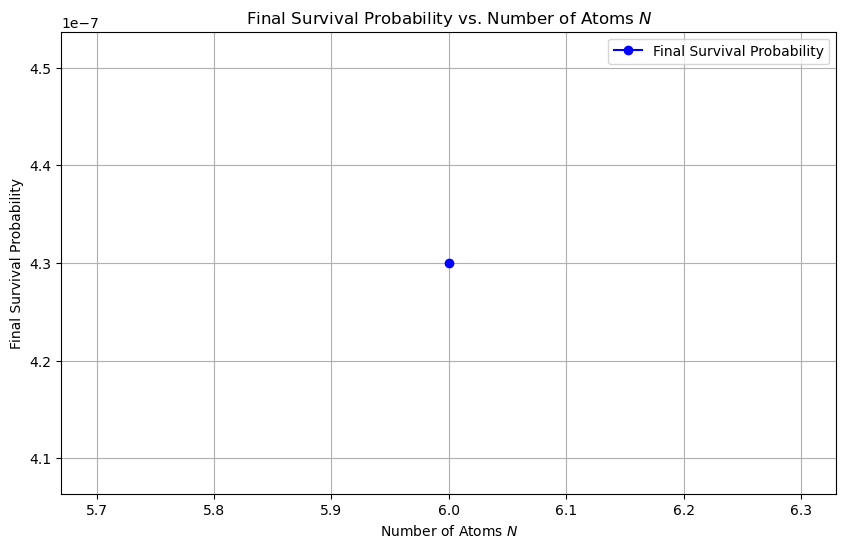

In [8]:
# Plot the final survival probability against N
Ns = sorted(optimization_results.keys())
final_survival_probabilities = [optimization_results[N]['final_survival_probability'] for N in Ns]

plt.figure(figsize=(10, 6))
plt.plot(Ns, final_survival_probabilities, 'bo-', label='Final Survival Probability')
plt.xlabel('Number of Atoms $N$')
plt.ylabel('Final Survival Probability')
plt.title('Final Survival Probability vs. Number of Atoms $N$')
plt.legend()
plt.grid(True)
plt.show()

# Optionally save the optimization results to a file
import pickle
with open('optimization_results.pkl', 'wb') as f:
    pickle.dump(optimization_results, f)